# 12. Continuous Latent Variables

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
%matplotlib inline

from prml.feature_extractions import PCA, BayesianPCA
import prml.neural_networks as pn

In [2]:
iris = datasets.load_iris()

## 12.1 Principal Component Analysis

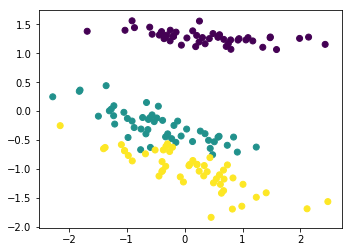

In [3]:
pca = PCA(n_components=2)
Z = pca.fit_transform(iris.data)
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 12.1.4 PCA for high-dimensional data

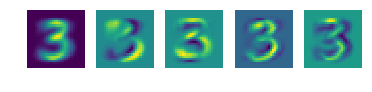

In [4]:
mnist = datasets.fetch_mldata("MNIST original")
mnist3 = mnist.data[np.random.choice(np.where(mnist.target == 3)[0], 200)]
pca = PCA(n_components=4)
pca.fit(mnist3)
plt.subplot(1, 5, 1)
plt.imshow(pca.mean.reshape(28, 28))
plt.axis('off')
for i, w in enumerate(pca.W.T[::-1]):
    plt.subplot(1, 5, i + 2)
    plt.imshow(w.reshape(28, 28))
    plt.axis('off')
plt.show()

### 12.2.2 EM algorithm for PCA

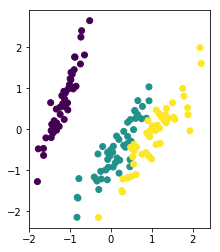

In [5]:
pca = PCA(n_components=2)
Z = pca.fit_transform(iris.data, method="em")
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 12.2.3 Bayesian PCA

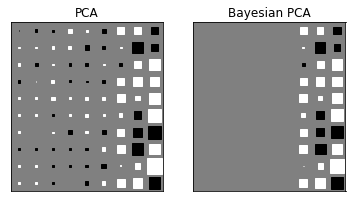

In [6]:
def create_toy_data(sample_size=100, ndim_hidden=1, ndim_observe=2, std=1.):
    Z = np.random.normal(size=(sample_size, ndim_hidden))
    mu = np.random.uniform(-5, 5, size=(ndim_observe))
    W = np.random.uniform(-5, 5, (ndim_hidden, ndim_observe))

    X = Z.dot(W) + mu + np.random.normal(scale=std, size=(sample_size, ndim_observe))
    return X

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([y - size / 2, x - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    plt.xlim(-0.5, np.size(matrix, 1) - 0.5)
    plt.ylim(-0.5, len(matrix) - 0.5)

X = create_toy_data(sample_size=100, ndim_hidden=3, ndim_observe=10, std=1.)
pca = PCA(n_components=9)
pca.fit(X)
bpca = BayesianPCA(n_components=9)
bpca.fit(X, initial="eigen")
plt.subplot(1, 2, 1)
plt.title("PCA")
hinton(pca.W)
plt.subplot(1, 2, 2)
plt.title("Bayesian PCA")
hinton(bpca.W)

### 12.4.2 Autoassociative neural networks

In [7]:
X = iris.data.astype(np.float32)

autoencoder = pn.Network()
autoencoder.add(pn.layers.MatMul(4, 3))
autoencoder.add(pn.layers.Tanh())
autoencoder.add(pn.layers.MatMul(3, 2), "encoded")
autoencoder.add(pn.layers.MatMul(2, 3))
autoencoder.add(pn.layers.Tanh())
autoencoder.add(pn.layers.MatMul(3, 4))
cost_func = pn.losses.SquaredError()
penalty_func = pn.losses.WeightDecay()
optimizer = pn.optimizers.AdamOptimizer(autoencoder, 1e-4)
for i in range(100000):
    logit = autoencoder.forward(X, training=True)
    if i % 10000 == 0:
        cost = cost_func(logit, X) + penalty_func(autoencoder)
        print("step %5d, cost %g" % (i, cost))
    delta = cost_func.backward(logit, X)
    autoencoder.backward(delta)
    penalty_func.backward(autoencoder)
    optimizer.update()

step     0, cost 3292.47
step 10000, cost 432.385
step 20000, cost 84.8275
step 30000, cost 20.8185
step 40000, cost 8.57548
step 50000, cost 7.96202
step 60000, cost 7.6356
step 70000, cost 7.35887
step 80000, cost 7.19383
step 90000, cost 7.10299


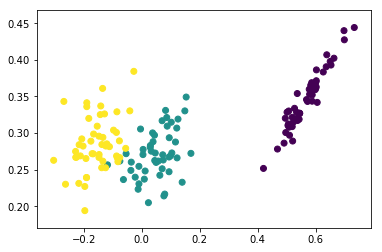

In [8]:
Z = autoencoder.forward(X, name="encoded")
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.show()